In [1]:
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass  # Чтобы не выводить названия файлов, оставляем пустой блок


In [2]:
from pathlib import Path

In [15]:
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

In [16]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))
from sklearn.model_selection import train_test_split

In [17]:
train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, random_state = 42, \
                                          stratify=train_val_labels)

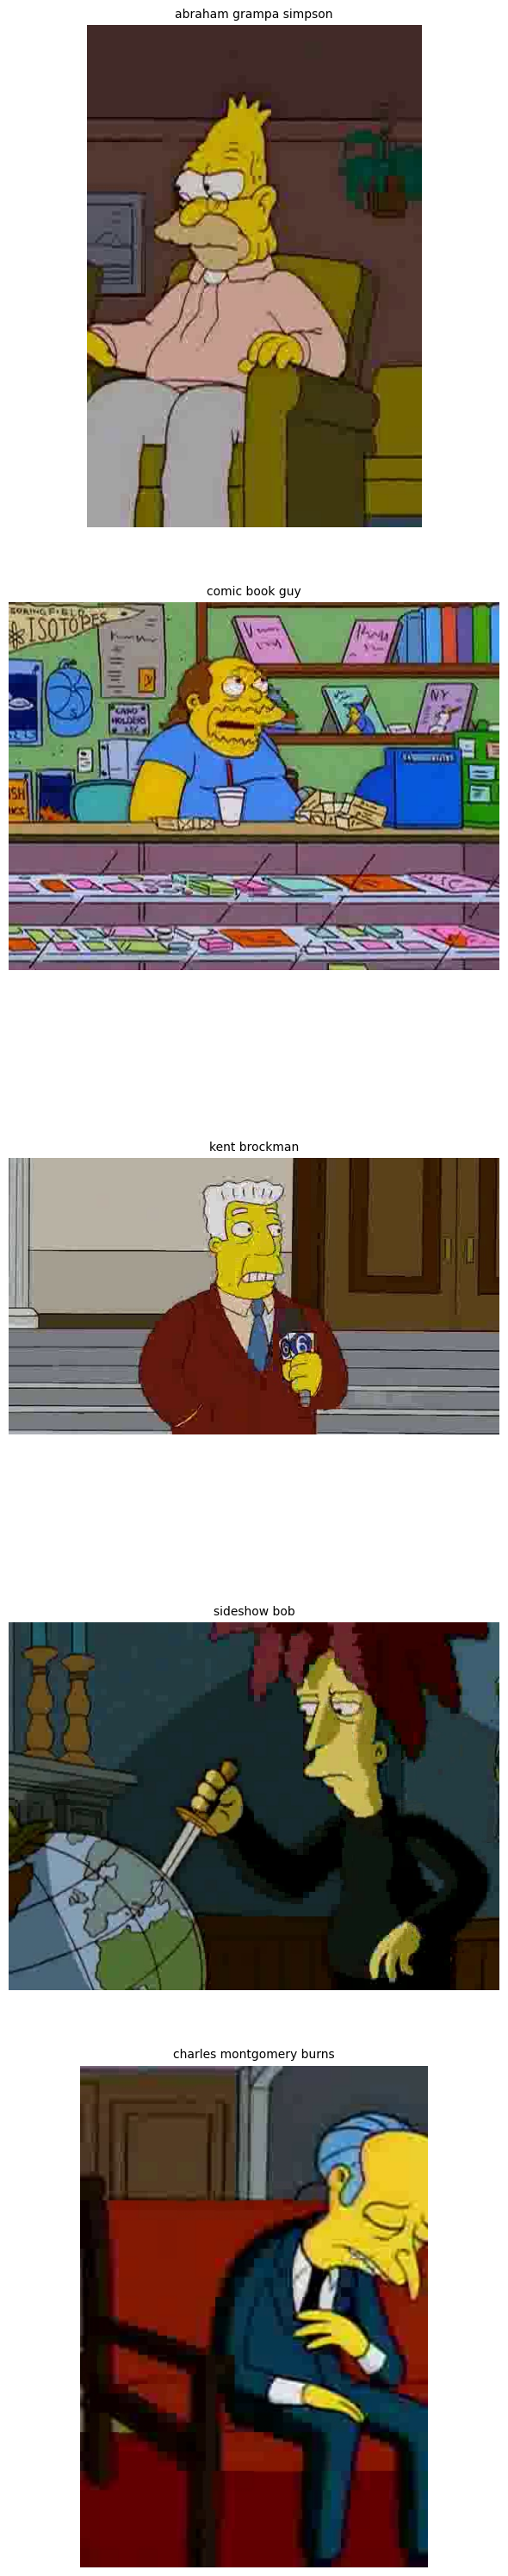

In [18]:
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path

train_files = [
    Path('train/simpsons_dataset/abraham_grampa_simpson/pic_0487.jpg'),
    Path('train/simpsons_dataset/comic_book_guy/pic_0267.jpg'),
    Path('train/simpsons_dataset/kent_brockman/pic_0337.jpg'),
    Path('train/simpsons_dataset/sideshow_bob/pic_0405.jpg'),
    Path('train/simpsons_dataset/charles_montgomery_burns/pic_0446.jpg')
]

fig, axs = plt.subplots(len(train_files), 1, figsize=(6, 6 * len(train_files)))  # Установка размеров изображений

for i, file_path in enumerate(train_files):
    img = Image.open(file_path)
    axs[i].imshow(img)
    axs[i].axis('off')
    title = file_path.parent.name.replace('_', ' ')
    axs[i].set_title(title, fontsize=10)  # Размер шрифта для заголовка

plt.tight_layout()
plt.show()

In [19]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout,GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import History, Callback
from sklearn.metrics import f1_score
import time

In [20]:
# Задаем параметры модели
IMG_SIZE = 224
BATCH_SIZE = 128
NUM_CLASSES = len(set(train_val_labels))

In [21]:
# Создаем генераторы данных для обучения и валидации
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)

In [22]:
train_generator = train_datagen.flow_from_directory(TRAIN_DIR, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='categorical')
val_generator = val_datagen.flow_from_directory(TRAIN_DIR, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='categorical')

Found 20933 images belonging to 42 classes.
Found 20933 images belonging to 42 classes.


In [23]:
# Создаем модель CNN
inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = Conv2D(32, (3, 3), activation='relu')(inputs)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

2024-07-15 12:30:37.251503: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 77971 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:07:00.0, compute capability: 8.0
2024-07-15 12:30:37.253885: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 79087 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:0a:00.0, compute capability: 8.0
2024-07-15 12:30:37.255872: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 79087 MB memory:  -> device: 2, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:47:00.0, compute capability: 8.0
2024-07-15 12:30:37.257853: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 79087 MB memory:  -> device: 3, name: NVIDIA A100-SXM4-80GB, pci bu

In [24]:
# Компилируем модель и задаем метрику f1-score
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [25]:
# Создаем колбэк для вывода истории обучения epochs и время
class TimingCallback(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        print('Epoch', epoch, 'time:', round(time.time() - self.start_time, 2), 's')

In [26]:
# Обучаем модель
history = model.fit(train_generator, epochs=10, validation_data=val_generator, callbacks=[History(), TimingCallback()])

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1721046675.058190  228326 service.cc:145] XLA service 0x7f70f4004500 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1721046675.058249  228326 service.cc:153]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
I0000 00:00:1721046675.058263  228326 service.cc:153]   StreamExecutor device (1): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
I0000 00:00:1721046675.058280  228326 service.cc:153]   StreamExecutor device (2): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
I0000 00:00:1721046675.058292  228326 service.cc:153]   StreamExecutor d

  2/164 ━━━━━━━━━━━━━━━━━━━━ 13s 84ms/step - loss: 4.5763 - precision: 0.0432 - recall: 0.0137         

I0000 00:00:1721046684.817477  228326 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


143/164 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - loss: 3.0576 - precision: 0.4436 - recall: 0.0431

I0000 00:00:1721046839.193961  228739 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_900', 48 bytes spill stores, 48 bytes spill loads

I0000 00:00:1721046839.335927  228721 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_900', 488 bytes spill stores, 448 bytes spill loads



163/164 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 2.9845 - precision: 0.4774 - recall: 0.0533

I0000 00:00:1721046858.054329  229102 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_91', 12 bytes spill stores, 12 bytes spill loads

I0000 00:00:1721046858.507704  229105 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_91', 56 bytes spill stores, 56 bytes spill loads

I0000 00:00:1721046888.852904  229181 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_91', 136 bytes spill stores, 136 bytes spill loads

I0000 00:00:1721046889.191972  229251 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_91', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1721046889.688255  229208 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_91', 12 bytes spill stores, 12 bytes spill loads



Epoch 0 time: 225.16 s
164/164 ━━━━━━━━━━━━━━━━━━━━ 225s 1s/step - loss: 2.9777 - precision: 0.4805 - recall: 0.0544 - val_loss: 1.6635 - val_precision: 0.8108 - val_recall: 0.3715
Epoch 2/10
163/164 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 1.6885 - precision: 0.8034 - recall: 0.3666Epoch 1 time: 203.75 s
164/164 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - loss: 1.6877 - precision: 0.8036 - recall: 0.3669 - val_loss: 1.2142 - val_precision: 0.8809 - val_recall: 0.5113
Epoch 3/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 1.2568 - precision: 0.8429 - recall: 0.5088Epoch 2 time: 202.49 s
164/164 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - loss: 1.2567 - precision: 0.8429 - recall: 0.5089 - val_loss: 0.9061 - val_precision: 0.9195 - val_recall: 0.6121
Epoch 4/10
163/164 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.9850 - precision: 0.8665 - recall: 0.6129Epoch 3 time: 203.23 s
164/164 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - loss: 0.9848 - precision: 0.8665 - recall: 0.6130 - val_loss: 0.6713 - val_precision

In [27]:
# Оцениваем модель на валидационном наборе данных
val_generator = val_datagen.flow_from_directory(TRAIN_DIR, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='categorical')
val_loss, val_precision, val_recall = model.evaluate(val_generator)
val_f1_score = 2 * (val_precision * val_recall) / (val_precision + val_recall)
print('Validation Loss:', val_loss)
print('Validation Precision:', val_precision)
print('Validation Recall:', val_recall)
print('Validation F1-Score:', val_f1_score)

Found 20933 images belonging to 42 classes.
164/164 ━━━━━━━━━━━━━━━━━━━━ 29s 176ms/step - loss: 0.1349 - precision: 0.9776 - recall: 0.9509
Validation Loss: 0.13077129423618317
Validation Precision: 0.9792259931564331
Validation Recall: 0.952515184879303
Validation F1-Score: 0.9656859195375749


### Результат модели: 
* Validation Loss: 0.10552750527858734
* Validation Precision: 0.98334801197052
* Validation Recall: 0.9619739055633545
* Validation F1-Score: 0.9725435354190104

In [28]:
# Предсказываем классы для тестовых изображений
import pandas as pd

test_files = sorted(list(TEST_DIR.rglob('*.jpg')))
test_filenames = [path.name for path in test_files]

test_df = pd.DataFrame({'filename': test_filenames})
test_df['label'] = 'unknown'

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        directory=str(TEST_DIR),
        x_col='filename',
        y_col=None,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode=None,
        shuffle=False
)

test_pred = model.predict(test_generator)
test_pred_classes = test_pred.argmax(axis=-1)


Found 991 validated image filenames.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step

I0000 00:00:1721049536.709079  232966 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_63', 136 bytes spill stores, 136 bytes spill loads

I0000 00:00:1721049537.272195  232945 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_63', 168 bytes spill stores, 168 bytes spill loads



8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 460ms/step


In [29]:

# Получаем реальные названия классов
class_names = train_generator.class_indices
class_names = {v: k for k, v in class_names.items()}

# Преобразуем числовые метки классов в текстовые
test_pred_class_names = [class_names[c] for c in test_pred_classes]

# Сохраняем результаты в файл
test_filenames = [path.name for path in test_files]
test_results = pd.DataFrame({'Id': test_filenames, 'Expected': test_pred_class_names})
test_results.to_csv('submission2.csv', index=False)


: 

### Пробуем базовые модели

In [ ]:
# Задаем параметры модели
IMG_SIZE = 224
BATCH_SIZE = 64
NUM_CLASSES = len(set(train_val_labels))

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input

# Загрузка предобученной модели MobileNetV2 без верхних слоев и с входным размером (IMG_SIZE, IMG_SIZE, 3)
base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                         include_top=False)

# Замораживаем веса базовой модели
base_model.trainable = False

# Создаем модель на основе базовой MobileNetV2
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs

# Компилируем модель и задаем метрику f1-score
model.compile(loss='categorical_crossentropy', metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [ ]:
history = model.fit(train_generator, epochs=10, validation_data=val_generator, callbacks=[History(), TimingCallback()])

In [ ]:
# Оцениваем модель на валидационном наборе данных
val_generator = val_datagen.flow_from_directory(TRAIN_DIR, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='categorical')
val_loss, val_precision, val_recall = model.evaluate(val_generator)
val_f1_score = 2 * (val_precision * val_recall) / (val_precision + val_recall)
print('Validation Loss:', val_loss)
print('Validation Precision:', val_precision)
print('Validation Recall:', val_recall)
print('Validation F1-Score:', val_f1_score)

In [ ]:
torch.cuda.empty_cache()


### Результат модели с MobileNetV2 
* Validation Loss: 0.5513983368873596
* Validation Precision: 0.9142679572105408
* Validation Recall: 0.7723212242126465
* Validation F1-Score: 0.8373213296380898